In [1]:
import torch
# from __future__ import absolute_import
# from __future__ import print_function

from itertools import product

import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import gym
import torch.optim as optim
from matplotlib import pylab as plt

import relaxit

from relaxit.rl_benchmarks.algorithms.reinforce import REINFORCE
from relaxit.rl_benchmarks.algorithms.a2c import A2C
from relaxit.rl_benchmarks.algorithms.relax import RELAX

In [2]:
# Plot formatting
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [3]:
def get_z_tilde_z_samples_params(logits):  # logits = log P(b | theta)
    u = torch.rand_like(logits, device=logits.device)
    v = torch.rand_like(logits, device=logits.device)
    z = logits - torch.log(-torch.log(u))
    samples = torch.argmax(z)

    tilde_z = -torch.log(-torch.log(v)/torch.exp(logits) -
                         torch.log(v)[samples])
    tilde_z[samples] = -torch.log(-torch.log(v))[samples]

    return z, tilde_z, samples

In [4]:
import gym
import torch.optim as optim
from matplotlib import pylab as plt



def apply_benchmark(algorithm : str = 'REINFORCE', 
                    env_name = 'CartPole-v1', 
                    max_steps : int = 256,
                    max_episode: int = 100):
    LR = 0.002  # Learning rate
    SEED = 42  # Random seed for reproducibility
    #MAX_EPISODES = 350  # Max number of episodes
    LOG_INTERVAL = 10
    HIDDEN_SIZE: int = 64

    # Init actor-critic agent
    if algorithm == 'REINFORCE':
        agent = REINFORCE(gym.make(env_name), hidden_size=HIDDEN_SIZE, gamma=.99, max_steps = max_steps, random_seed=SEED)
    elif algorithm == 'RELAX':
        agent = RELAX(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, max_steps = max_steps, random_seed=SEED)
    elif algorithm == 'A2C':
        agent = A2C(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, max_steps = max_steps, random_seed=SEED)

    # Init optimizers
    actor_optim = optim.Adam(agent.actor.parameters(), lr=LR)
    if algorithm != 'REINFORCE':
        critic_optim = optim.Adam(agent.critic.parameters(), lr=LR)

    #
    # Train
    #

    r = []  # Array containing total rewards
    avg_r = 0  # Value storing average reward over last 100 episodes

    running_reward = 0

    ep_rewards = []
    running_rewards = []

    for i in range(max_episode):
        if algorithm == 'REINFORCE':
            total_reward = agent.train_one_episode(optimizer=actor_optim)
        else:
            total_reward = agent.train_one_episode(actor_optimizer=actor_optim, critic_optimizer=critic_optim)

        ep_reward = total_reward
        if running_reward == 0:
            running_reward = ep_reward
        running_reward = 0.01 * ep_reward + (1 - 0.01) * running_reward
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        
        if i % LOG_INTERVAL == 0:
            print(
                "Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}".format(
                    i, ep_reward, running_reward
                )
            )
        if running_reward > agent.env.spec.reward_threshold:
            print(
                "Solved! Running reward is now {} and ".format(running_reward)
            )
            break
    return running_rewards

In [5]:
algorithm2rewards = {}

In [6]:
algorithm2rewards = {}
for algorithm in ['RELAX', 'REINFORCE', 'A2C']:
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm, env_name = 'CartPole-v1', max_episode = 200, max_steps = 70)

/home/machenike/my_ML_env/env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 13.00	Average reward: 13.00
Episode 10	Last reward: 30.00	Average reward: 14.54
Episode 20	Last reward: 44.00	Average reward: 15.77
Episode 30	Last reward: 21.00	Average reward: 16.81
Episode 40	Last reward: 19.00	Average reward: 17.99
Episode 50	Last reward: 29.00	Average reward: 19.18
Episode 60	Last reward: 13.00	Average reward: 20.14
Episode 70	Last reward: 34.00	Average reward: 21.78
Episode 80	Last reward: 24.00	Average reward: 22.52
Episode 90	Last reward: 19.00	Average reward: 23.85
Episode 100	Last reward: 18.00	Average reward: 24.99
Episode 110	Last reward: 58.00	Average reward: 26.61
Episode 120	Last reward: 70.00	Average reward: 28.01
Episode 130	Last reward: 36.00	Average reward: 29.35
Episode 140	Last reward: 47.00	Average reward: 31.40
Episode 150	Last reward: 31.00	Average reward: 33.23
Episode 160	Last reward: 43.00	Average reward: 35.52
Episode 170	Last reward: 29.00	Average reward: 37.14
Episode 180	Last reward: 68.00	Average reward: 39.32
Epis

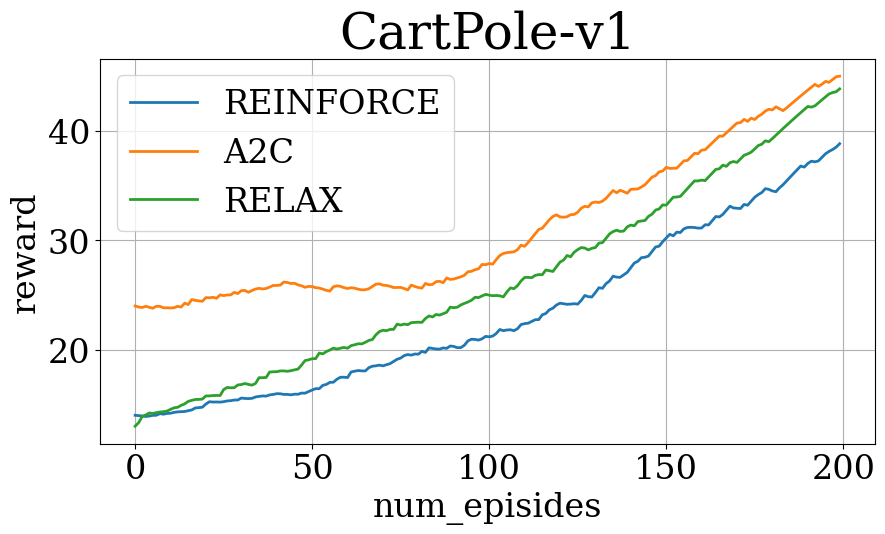

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'CartPole-v1',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()

In [8]:
algorithm2rewards = {}
for algorithm in ['REINFORCE', 'A2C']: #'RELAX', 
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm,
                                                   env_name='Acrobot-v1',
                                                   max_episode=200,
                                                   max_steps = 650)

Episode 0	Last reward: -650.00	Average reward: -650.00
Episode 10	Last reward: -216.00	Average reward: -635.54
Episode 20	Last reward: -253.00	Average reward: -602.97
Episode 30	Last reward: -172.00	Average reward: -566.83
Episode 40	Last reward: -143.00	Average reward: -529.68
Episode 50	Last reward: -138.00	Average reward: -498.35
Episode 60	Last reward: -191.00	Average reward: -467.13
Episode 70	Last reward: -154.00	Average reward: -440.32
Episode 80	Last reward: -153.00	Average reward: -415.22
Episode 90	Last reward: -203.00	Average reward: -392.54
Episode 100	Last reward: -395.00	Average reward: -376.16
Episode 110	Last reward: -141.00	Average reward: -356.19
Episode 120	Last reward: -141.00	Average reward: -338.99
Episode 130	Last reward: -138.00	Average reward: -325.06
Episode 140	Last reward: -152.00	Average reward: -313.26
Episode 150	Last reward: -161.00	Average reward: -296.64
Episode 160	Last reward: -359.00	Average reward: -287.78
Episode 170	Last reward: -224.00	Average r

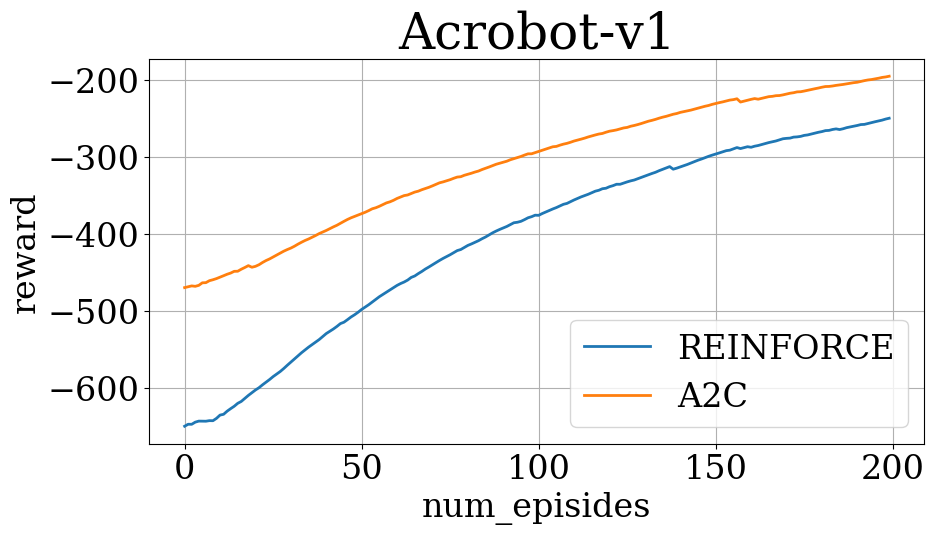

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'Acrobot-v1',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()

In [10]:
algorithm2rewards = {}
for algorithm in ['RELAX', 'REINFORCE', 'A2C']: 
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm,
                                                   env_name='Taxi-v3',
                                                   max_episode=200,
                                                   max_steps = 30)

Episode 0	Last reward: -129.00	Average reward: -129.00
Episode 10	Last reward: -75.00	Average reward: -127.29
Episode 20	Last reward: -129.00	Average reward: -125.39
Episode 30	Last reward: -102.00	Average reward: -122.53
Episode 40	Last reward: -120.00	Average reward: -121.59
Episode 50	Last reward: -129.00	Average reward: -120.16
Episode 60	Last reward: -102.00	Average reward: -118.51
Episode 70	Last reward: -84.00	Average reward: -116.57
Episode 80	Last reward: -120.00	Average reward: -116.28
Episode 90	Last reward: -120.00	Average reward: -113.82
Episode 100	Last reward: -57.00	Average reward: -112.00
Episode 110	Last reward: -84.00	Average reward: -109.48
Episode 120	Last reward: -102.00	Average reward: -108.59
Episode 130	Last reward: -138.00	Average reward: -107.21
Episode 140	Last reward: -57.00	Average reward: -104.52
Episode 150	Last reward: -57.00	Average reward: -101.79
Episode 160	Last reward: -84.00	Average reward: -99.07
Episode 170	Last reward: -66.00	Average reward: -9

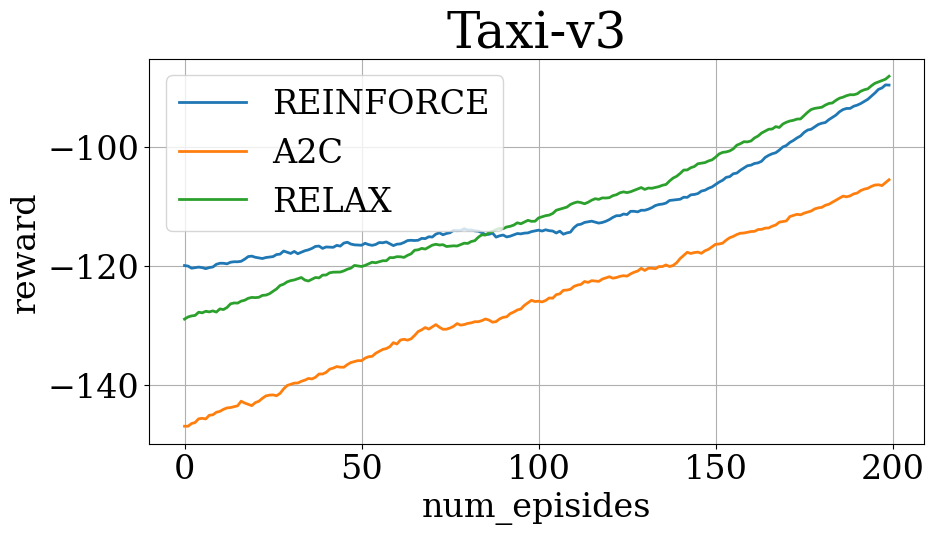

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    if algorithm in algorithm2rewards:
        ax.plot(algorithm2rewards[algorithm], label = algorithm)
ax.legend()
ax.set(
    title = 'Taxi-v3',
    ylabel = 'reward',
    xlabel = 'num_episides'
)
ax.grid()
plt.show()